# Comparison of Different Algorithmic Trading Strategies on Tesla Stock Price

### Tawfiq Jawhar
<b>Machine Learning (COMP-652 and ECSE-608)<br>
Fall 2018<br>
McGill University <br><br>
Instructors:<br>
Audrey Durand<br>
Riashat Islam <br></b>

---

## Outline
As we saw before, the logarithmic return of TSLA price does not come from a Normal distribution. However, can we find a mixture of distibutions?
If we can detect a regime where it has high volatility, then we can use that model as a risk safe strategy to not invest when the stock is in that regime. 

We will use Gaussian Mixture Models to cluster the return into different Normal distributions.
This work is inspired from Brain's notebooks [Mixture Model Trading.](https://github.com/BlackArbsCEO/mixture_model_trading_public)

In [1]:
## inline plot
%matplotlib inline

##import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import dateutil.parser
import numpy as np 
import scipy.stats as stats
import sklearn.mixture as mix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics.cluster import adjusted_mutual_info_score
import itertools

plt.style.use('seaborn-darkgrid')
#plt.style.use("seaborn-whitegrid")
#plt.style.use('bmh')
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
colors = sns.color_palette('deep', 6)
#colors = [colors[0],colors[3],colors[2]] #take blue ,red and green
RANDOM_STATE = 123

In [2]:
## load the TSLA price data
df = pd.read_pickle('data/TSLAtraining.pickle')
TSLA = df['TSLA']
## get the returns
returns = np.log(TSLA/TSLA.shift(1)).dropna()

df_testing = pd.read_pickle('data/TSLAtesting.pickle')
TSLA_testing = df_testing['TSLA']
## get the returns
returns_testing = np.log(TSLA_testing/TSLA_testing.shift(1)).dropna()


Using `sklearn.mixture.GaussianMixture` module, we will fit the return data on GMMs with different number of components. We will use he Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) to determine the best number of components to use. AIC and BIC adds a penalty to the likelihood as numbers of components increase. BIC has a higher penalty than AIC for having more parameters in the model. Which can be a better measure to not overfit. We will also compare different covariance matrices; spherical, diagonal, full and tied. 

In [3]:
## taken from https://github.com/BlackArbsCEO/mixture_model_trading_public/blob/master/notebooks/02.%20Gaussian%20Mixtures-updated.ipynb
def make_gmm(n_components, max_iter=150, random_state=RANDOM_STATE, covariance_type='spherical'):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, 
                      max_iter=max_iter,
                      n_init=100,
                      random_state=RANDOM_STATE,
                      covariance_type=covariance_type)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

In [4]:
max_iter = 150 
_X = returns.values.reshape(-1, 1)


n_components = np.arange(1,7)
aics = []
bics = []
lowest_bic = np.infty
lowest_aic = np.infty

cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n in n_components:
        # Fit a Gaussian mixture with EM
        
        tmp_gmm = make_gmm(n_components=n,
                           covariance_type=cv_type).fit(_X)

        bics.append(tmp_gmm.bic(_X))
        if bics[-1] < lowest_bic:
            lowest_bic = bics[-1]
        aics.append(tmp_gmm.aic(_X))
        if aics[-1] < lowest_aic:
            lowest_aic = aics[-1]


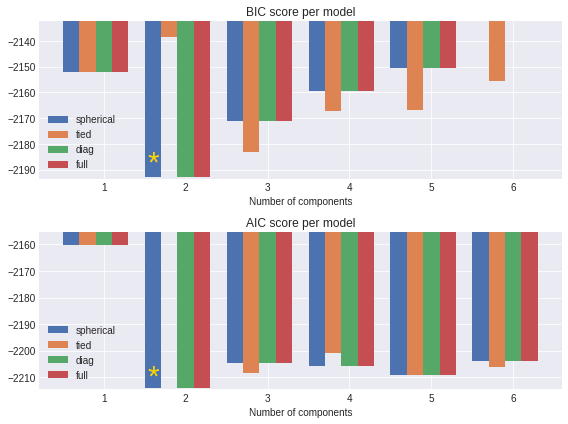

In [5]:
##plot the results.
bic = np.array(bics)
aic = np.array(aics)
color_iter = colors#itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              #'darkorange'])
#clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components):
                                  (i + 1) * len(n_components)], width=.2, color=color))
plt.xticks(n_components)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components)) + .53 +\
    .2 * np.floor(bic.argmin() / len(n_components))
plt.text(xpos, bic.min() * 0.96 + .04 * bic.max(), '*', fontsize=30,color='gold')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


bars = []

# Plot the AIC scores
#plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 2)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components):
                                  (i + 1) * len(n_components)], width=.2, color=color))
plt.xticks(n_components)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('AIC score per model')
xpos = np.mod(bic.argmin(), len(n_components)) + .53 +\
    .2 * np.floor(bic.argmin() / len(n_components))
plt.text(xpos, bic.min() * 0.98 + .03 * bic.max(), '*', fontsize=30,color='gold')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


#plt.xticks(())
#plt.yticks(())
#plt.title('Selected GMM: full model, 2 components')
#plt.subplots_adjust(hspace=.35, bottom=.02)
plt.tight_layout()
plt.show()

The result clearly shows that 2 components would be best to use. And the best covariance matrix is spherical, although diagonal and full returned close results. 

Before we use the model to predict the testing set, let's visualize the two clusters. We will plot the TSLA price with different color for each cluster. 

In [6]:
gmm = make_gmm(2, max_iter,covariance_type='spherical').fit(_X)

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


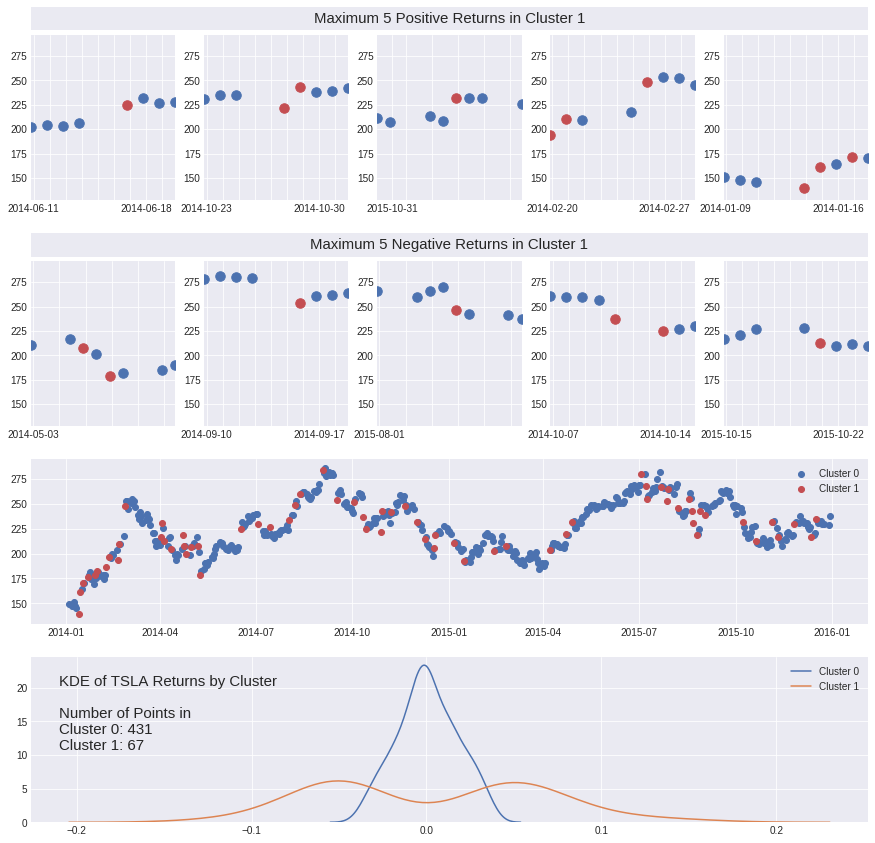

In [7]:
n = 2
gmm = make_gmm(n, max_iter).fit(_X)
fig = plt.figure(figsize=(15,15))
labels = gmm.predict(_X)
## use blue and red colors
clrs=[colors[0], colors[3]]

grid=(29,5)

## plot all the data at the end
#ax1 = plt.subplot(14,1,)
ax1=plt.subplot2grid(grid,(16,0),rowspan=6,colspan=5)

for i in range(2):
    #plt points in region 0
    x= TSLA.index[1:returns.shape[0]+1][[False if x!=i else True for x in labels]]
    y = TSLA[1:returns.shape[0]+1][[False if x!=i else True for x in labels]]
    ax1.scatter(x,y, color=clrs[i],alpha=1, label='Cluster '+str(i))
    
ax1.legend(loc='best')
##plot text for maximum
#ax2=plt.subplot(14,1,1)
with sns.axes_style("dark"):
    ax2=plt.subplot2grid(grid,(0,0),rowspan=1,colspan=5)
    ax2.text(0.5,0.5,"Maximum 5 Positive Returns in Cluster 1", horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    #ax2.patch.set_visible(False)
    #ax2.axis('off')


##get highest 5 returns 
max5=returns[[True if x==1 else False for x in labels]].sort_values()[-5:].index
for j in range(5):
    arg = returns.index.get_loc(max5[j])
    #ax=plt.subplot(14,5,j+1)
    ax=plt.subplot2grid(grid,(1,j),rowspan=6,colspan=1)
    ax.set_xlim()
    ax.set_xlim(TSLA.index[arg-3],TSLA.index[arg+4])           # Values >0.0 zoom out
    for i in range(2):
        #plt points in region 0
        x= TSLA.index[1:returns.shape[0]+1][[False if x!=i else True for x in labels]]
        y = TSLA[1:returns.shape[0]+1][[False if x!=i else True for x in labels]]
        ax.scatter(x,y, color=clrs[i], s=90,alpha=1)
    every_nth = 7
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

##plot text for minimum
#ax2=plt.subplot(14,1,1)
with sns.axes_style("dark"):

    ax3=plt.subplot2grid(grid,(8,0),rowspan=1,colspan=5)
    ax3.text(0.5,0.5,"Maximum 5 Negative Returns in Cluster 1", horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    #ax3.patch.set_visible(False)
    #ax3.axis('off')

        
##get lowest 5 returns 
min5=returns[[True if x==1 else False for x in labels]].sort_values()[:5].index
for j in range(5):
    arg = returns.index.get_loc(min5[j])
    #ax=plt.subplot(14,5,j+6)
    ax=plt.subplot2grid(grid,(9,j),rowspan=6,colspan=1)
    ax.set_xlim()
    ax.set_xlim(TSLA.index[arg-3],TSLA.index[arg+4])           # Values >0.0 zoom out
    for i in range(2):
        #plt points in region 0
        x= TSLA.index[1:returns.shape[0]+1][[False if x!=i else True for x in labels]]
        y = TSLA[1:returns.shape[0]+1][[False if x!=i else True for x in labels]]
        ax.scatter(x,y, color=clrs[i], s=90,alpha=1)
    every_nth = 7
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
ax4=plt.subplot2grid(grid,(23,0),rowspan=6,colspan=5)
no_returns0=returns[[True if x==0 else False for x in labels]].shape[0]
no_returns1=returns[[True if x==1 else False for x in labels]].shape[0]

sns.kdeplot(returns[[True if x==0 else False for x in labels]],label='Cluster 0',color=colors[0],ax=ax4)
sns.kdeplot(returns[[True if x==1 else False for x in labels]], label='Cluster 1',color=colors[1],ax=ax4)
ax4.text(-0.21,22,"KDE of TSLA Returns by Cluster\n\nNumber of Points in\nCluster 0: "\
         +str(no_returns0)+"\nCluster 1: "+str(no_returns1),fontsize=15,
        horizontalalignment='left',verticalalignment='top')
#ax4.set_title("KDE of TSLA Returns by Cluster",fontsize=15)
plt.show()


The KDE of the returns for each cluster clearly shows that most of the returns (431/498) follow a stable return with mean 0. However, returns in cluster 1 (67/498) have higher returns. <b>Cluster 1 can be identified as outlier in the movement of the price. Which can also identify a high risk for trading.</b>

We can also see the price movemenent at the maximum 5 positive/negative returns. It is interesting to notice that <b>5 out of the 10 happen after a weekend</b> (2 days market close). 

This raises few questions:
-  Is weekend correlated with outlier movement of the price?
-  Can we predict an outlier before it happens?

Before we deal with these questions, let us test if the same clusters fit on the training data can predict outliers in the testing data properly. 

To do so, we will use the GMM model fit on the training data to predict the testing data. We will also fit a new GMM model on the testing data and use it to predict the testing data; we will assume this prediction is the true label of the testing data. 

Then we will use the Adjusted Mutual Information (AMI) score to compare the two predictions. AMI calculates the information shared between clusters from the two models. AMI is symmetrical as well which works well for comparing two clustering models.

If the same returns are clustered together in both models then AMI score will be 1.

We will use `sklearn.metrics.adjusted_mutual_info_score`

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_sc

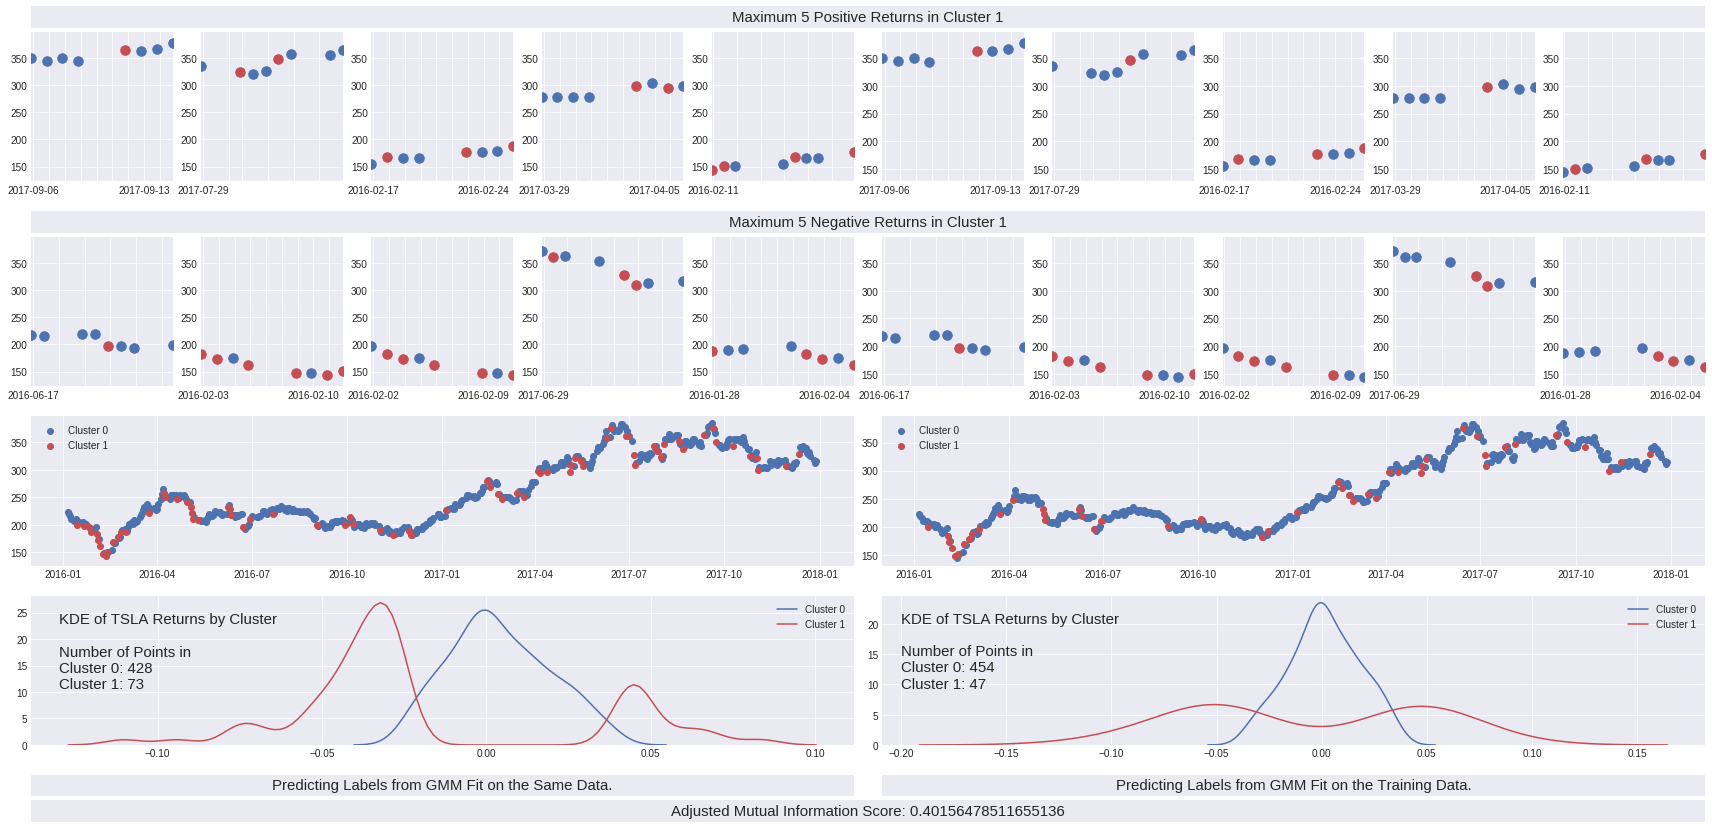

In [8]:
fig = plt.figure(figsize=(30,15))
grid=(32,10)

################
## True Labels
#################
_X_testing = returns_testing.values.reshape(-1, 1)
gmm_testing = make_gmm(2, max_iter).fit(_X_testing)
n = 2
labels = gmm_testing.predict(_X_testing)

no_returns0=returns_testing[[True if x==0 else False for x in labels]].shape[0]
no_returns1=returns_testing[[True if x==1 else False for x in labels]].shape[0]

if no_returns0 < no_returns1:
    ## flip the labels:
    labels = [1 if x == 0 else 0 for x in labels]



## plot all the data at the end
#ax1 = plt.subplot(14,1,)
ax1=plt.subplot2grid(grid,(16,0),rowspan=6,colspan=5)

for i in range(2):
    #plt points in region 0
    x= TSLA_testing.index[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
    y = TSLA_testing[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
    ax1.scatter(x,y, color=clrs[i],alpha=1, label='Cluster '+str(i))
    
ax1.legend(loc='best')
##plot text for maximum
#ax2=plt.subplot(14,1,1)
with sns.axes_style("dark"):
    ax2=plt.subplot2grid(grid,(0,0),rowspan=1,colspan=10)
    ax2.text(0.5,0.5,"Maximum 5 Positive Returns in Cluster 1", horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    #ax2.patch.set_visible(False)
    #ax2.axis('off')


##get highest 5 returns 
max5=returns_testing[[True if x==1 else False for x in labels]].sort_values()[-5:].index
for j in range(5):
    arg = returns_testing.index.get_loc(max5[j])
    #ax=plt.subplot(14,5,j+1)
    ax=plt.subplot2grid(grid,(1,j),rowspan=6,colspan=1)
    ax.set_xlim()
    ax.set_xlim(TSLA_testing.index[arg-3],TSLA_testing.index[arg+4])           # Values >0.0 zoom out
    for i in range(2):
        #plt points in region 0
        x= TSLA_testing.index[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
        y = TSLA_testing[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
        ax.scatter(x,y, color=clrs[i], s=90,alpha=1)
    every_nth = 7
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

##plot text for minimum
#ax2=plt.subplot(14,1,1)
with sns.axes_style("dark"):

    ax3=plt.subplot2grid(grid,(8,0),rowspan=1,colspan=10)
    ax3.text(0.5,0.5,"Maximum 5 Negative Returns in Cluster 1", horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    #ax3.patch.set_visible(False)
    #ax3.axis('off')

        
##get lowest 5 returns 
min5=returns_testing[[True if x==1 else False for x in labels]].sort_values()[:5].index
for j in range(5):
    arg = returns_testing.index.get_loc(min5[j])
    #ax=plt.subplot(14,5,j+6)
    ax=plt.subplot2grid(grid,(9,j),rowspan=6,colspan=1)
    ax.set_xlim()
    ax.set_xlim(TSLA_testing.index[arg-3],TSLA_testing.index[arg+4])           # Values >0.0 zoom out
    for i in range(2):
        #plt points in region 0
        x= TSLA_testing.index[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
        y = TSLA_testing[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
        ax.scatter(x,y, color=clrs[i], s=90,alpha=1)
    every_nth = 7
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
ax4=plt.subplot2grid(grid,(23,0),rowspan=6,colspan=5)
no_returns0=returns_testing[[True if x==0 else False for x in labels]].shape[0]
no_returns1=returns_testing[[True if x==1 else False for x in labels]].shape[0]

sns.kdeplot(returns_testing[[True if x==0 else False for x in labels]],label='Cluster 0',color=clrs[0],ax=ax4)
sns.kdeplot(returns_testing[[True if x==1 else False for x in labels]], label='Cluster 1',color=clrs[1],ax=ax4)
ax4.text(-0.13,25,"KDE of TSLA Returns by Cluster\n\nNumber of Points in\nCluster 0: "\
         +str(no_returns0)+"\nCluster 1: "+str(no_returns1),fontsize=15,
        horizontalalignment='left',verticalalignment='top')
#ax4.set_title("KDE of TSLA Returns by Cluster",fontsize=15)


#########
# Testing 
########
labels = gmm.predict(_X_testing)

no_returns0=returns_testing[[True if x==0 else False for x in labels]].shape[0]
no_returns1=returns_testing[[True if x==1 else False for x in labels]].shape[0]

if no_returns0 < no_returns1:
    ## flip the labels:
    labels = [1 if x == 0 else 0 for x in labels]


clrs = np.array(clrs)

## plot all the data at the end
#ax1 = plt.subplot(14,1,)
ax1=plt.subplot2grid(grid,(16,5),rowspan=6,colspan=5)

for i in range(2):
    #plt points in region 0
    x= TSLA_testing.index[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
    y = TSLA_testing[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
    ax1.scatter(x,y, color=clrs[i],alpha=1, label='Cluster '+str(i))
    
ax1.legend(loc='best')
"""
##plot text for maximum
#ax2=plt.subplot(14,1,1)
with sns.axes_style("dark"):
    ax2=plt.subplot2grid(grid,(0,0),rowspan=1,colspan=5)
    ax2.text(0.5,0.5,"Maximum 5 Positive Returns in Cluster 1", horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    #ax2.patch.set_visible(False)
    #ax2.axis('off')

"""
##get highest 5 returns 
max5=returns_testing[[True if x==1 else False for x in labels]].sort_values()[-5:].index
for j in range(5):
    arg = returns_testing.index.get_loc(max5[j])
    #ax=plt.subplot(14,5,j+1)
    ax=plt.subplot2grid(grid,(1,j+5),rowspan=6,colspan=1)
    ax.set_xlim()
    ax.set_xlim(TSLA_testing.index[arg-3],TSLA_testing.index[arg+4])           # Values >0.0 zoom out
    for i in range(2):
        #plt points in region 0
        x= TSLA_testing.index[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
        y = TSLA_testing[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
        ax.scatter(x,y, color=clrs[i], s=90,alpha=1)
    every_nth = 7
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
"""
##plot text for minimum
#ax2=plt.subplot(14,1,1)
with sns.axes_style("dark"):

    ax3=plt.subplot2grid(grid,(8,0),rowspan=1,colspan=5)
    ax3.text(0.5,0.5,"Maximum 5 Negative Returns in Cluster 1", horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    #ax3.patch.set_visible(False)
    #ax3.axis('off')

"""        
##get lowest 5 returns 
min5=returns_testing[[True if x==1 else False for x in labels]].sort_values()[:5].index
for j in range(5):
    arg = returns_testing.index.get_loc(min5[j])
    #ax=plt.subplot(14,5,j+6)
    ax=plt.subplot2grid(grid,(9,j+5),rowspan=6,colspan=1)
    ax.set_xlim()
    ax.set_xlim(TSLA_testing.index[arg-3],TSLA_testing.index[arg+4])           # Values >0.0 zoom out
    for i in range(2):
        #plt points in region 0
        x= TSLA_testing.index[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
        y = TSLA_testing[1:returns_testing.shape[0]+1][[False if x!=i else True for x in labels]]
        ax.scatter(x,y, color=clrs[i], s=90,alpha=1)
    every_nth = 7
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
ax4=plt.subplot2grid(grid,(23,5),rowspan=6,colspan=5)
no_returns0=returns_testing[[True if x==0 else False for x in labels]].shape[0]
no_returns1=returns_testing[[True if x==1 else False for x in labels]].shape[0]

sns.kdeplot(returns_testing[[True if x==0 else False for x in labels]],label='Cluster 0',color=clrs[0],ax=ax4)
sns.kdeplot(returns_testing[[True if x==1 else False for x in labels]], label='Cluster 1',color=clrs[1],ax=ax4)
ax4.text(-0.2,22,"KDE of TSLA Returns by Cluster\n\nNumber of Points in\nCluster 0: "\
         +str(no_returns0)+"\nCluster 1: "+str(no_returns1),fontsize=15,
        horizontalalignment='left',verticalalignment='top')

with sns.axes_style("dark"):
    ax5=plt.subplot2grid(grid,(30,0),rowspan=1,colspan=5)
    ax5.text(0.5,0.5,"Predicting Labels from GMM Fit on the Same Data.", horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
with sns.axes_style("dark"):
    ax5=plt.subplot2grid(grid,(30,5),rowspan=1,colspan=5)
    ax5.text(0.5,0.5,"Predicting Labels from GMM Fit on the Training Data.", horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
with sns.axes_style("dark"):
    true_labels = gmm_testing.predict(_X_testing)
    labels = gmm.predict(_X_testing)
    score = adjusted_mutual_info_score(labels, true_labels)
    ax5=plt.subplot2grid(grid,(31,0),rowspan=1,colspan=10)
    ax5.text(0.5,0.5,"Adjusted Mutual Information Score: "+str(score), horizontalalignment='center',
        verticalalignment='center',fontsize=15)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)        
plt.show()


Although the two models did not cluster the data perfectly the same, the prediction of the testing data from the training model was able to predict good regions where the return can be considered an outlier to the regular movement of the price. 

The Adjusted Mutual Information score is 0.4, however, the maximum pos/neg returns are the same predictions in both models. 
This can indicate that such risk detector using GMM can be used as part of a trading strategy to reduce the risk and prevent trading in high risk periods. 

When we apply the classification model, we will incorprate this information into our classifiers; instead of learning the movement of the return (going up or down), we can add two more classes for positive outlier and negative outlier. 